# Cost-Aware A/B Testing using Reinforcement Learning

1. [Background](#section01)
2. [Problem Statement](#section02)
3. [Problem Formulation](#section03)
4. [Simulation Setup](#section04)
5. [Solution Overview](#section05)
6. [Results Summary](#section06)

<a id='section01'></a>
## Background

A/B testing (a.k.a. randomized controlled trials, randomized experiments) is one of the most important ways to understand causal relationships. In a typical A/B testing setup, there will be one (or more) treatment group and one control group, and a pool of subjects are randomly assigned to the experimental groups based on pre-determined proportions (e.g., equal assignments). 

While this is a perfectly legitimate way to test causality, it can be inefficient in practice. Imagine a clinical trial of two treatment options: drug A and placebo B, and let's assume that (in fact) drug A is much more effective than placebo B in treating a certain condition. Then, every subject that is assigned to the placebo group has to (unfortunately) endure some non-trivial costs, i.e., their conditions are not treated timely even when an effective drug exists. Note that some of the costs are necessary - after all, we don't know the effectiveness of drug A a priori and need a sufficient number of people in both groups to find out. However, as the effectiveness of drug A becomes clearer and clearer over the course of the experiment, perhaps it makes sense to gradually reduce the assignment to the placebo group, in order to reduce costs. 

This is the basic idea behind **cost-aware A/B testing**. It is an important emerging topic in experimentation, and has attracted a lot of attention from both researchers and practitioners.

<a id='section02'></a>
## Problem Statement

Formally, consider an experiment with $k$ treatment options $\{T_1, \ldots, T_k\}$ (no need to explicitly differentiate between treatment and control in a traditional sense, one of these options could be a control condition). Each of the $k$ treatments has a true underlying treatment effect $\{TE_1, \ldots, TE_k\}$, which is unknown to the experimenter before the experiment is conducted. For an arbitrary subject $i$ that is assigned to a treatment $j$, the realized treatment effect $TE_{ij}$ is a random draw from the normal distribution surrounding the true treatment effect with unknown variance, i.e., $TE_{ij} \sim N(TE_j, \sigma^2_j)$. There are $N$ subjects available in total, who can be assigned to the different treatment groups. The goal of the experimenter is twofold: (1) the experimenter wants to understand the effectiveness of each treatment option (this is why the experiment is conducted in the first place); (2) at the same time, the experimenter wants to be cost-aware in treatment assignment and try to avoid incurring too much costs.

<a id='section03'></a>
## Problem Formulation
To implement this cost-aware AB testing, we can leverage a reinforcement learning model such that:
* **Agent** is the decision-maker that takes each subject $i$ and assign it into treatment $j$;
* **Environment** consists of predefined $N$ the total available subjects and distributions of Treatment Effects $N(TE_j, \sigma^2_j)$;
* **Action** is assigning a subject at a time;
* **Reward** is two-folds given the objective. A high reward can be either we get significant measure of treatment effects from treatment group(s) or assign a subject into a group with high treatment effect;
* **States** are the status each subject is in which treatment group and the treatment effects gained;
* **Value** is how useful each action in achieving higher reward;
* **Policy** is a mapping between the states and actions to take;



<a id='section04'></a>
## Simulation Setup
Simulate 10 treatment groups with treatment effects defined by normal distributions:
* First, simulate the true expected reward, r_i, of each treatment group
* Second, simulate variance of each treatment effect
* Create a function to return treatment effects from treatment groups

In [9]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestPower
from scipy.stats import ttest_1samp
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')


In [3]:
k = 10
T = 1000
# First, simulate the true expected reward, r_i, of each treatment group
# set a seed so the results are reproducible
np.random.seed(1222)
treatment_effects = np.random.rand(k)*2*np.random.choice([-1, 1],k)
# Second, simulate variance of each treatment effect
TE_variance = np.random.rand(k)*10
TE_std = np.sqrt(TE_variance)

In [3]:
print("Treatment effects: ", treatment_effects)
print("Standard deviation: ", TE_std)

Treatment effects:  [-0.13497056 -0.66988599 -0.73678849  0.96718971 -0.92762549 -0.07576029
  0.13129848  0.1735954   1.91141982 -0.35154033]
Standard deviation:  [0.71418956 2.02434067 1.92901581 1.98196116 1.49346104 2.42566794
 2.78529598 2.02744984 1.31210247 3.03084882]


In [4]:
def pull(group_ind):
    """
    Return TE from treatment group
    """
    return np.random.normal(loc = treatment_effects[group_ind], scale = TE_std[group_ind])

<a id='section05'></a>
## Solution Overview
To achieve the the goal that: (1) understand the effectiveness of each treatment option (2) avoid incurring too much costs, I designed a two staged solution:

**Stage1**: Assign enough subjects into each treatment group to reach certain acceptable estimates of treatment effects. To complete Stage1, consider one of the below results:
1. We get a statistically siginificant(alpha=0.05) result from the groups
2. OR reach 80% power sample size target

However, to be cost-aware, set a hard limit to end Stage1, so we avoid running out of samples in stage1, e.g. 50% of all subjects. *To initialize the minimum sample size calculation, assign some subjects into each group, in this case 10*.

**Stage2**: Assign more subjects into treatment groups of higher treatment effects. To make the comparison, apply a multiplier(0-1) to each non-stats sig. treatment effect to discount for large variance. Several strategies are tested: 
1. Greedy strategy
2. $\varepsilon$-greedy strategy
3. Gradient method

In [5]:
def min_sample_size(effect_size):
    """
    Return required sample size to achieve 80% power
    """
    alpha = 0.05  # The significance level
    power = 0.8  # The desired power of the test
    nobs = None  # The sample size(None for automatic calculation)
    alternative = 'two-sided'  # The alternative hypothesis
    # Create an instance of the TTestIndPower class
    power_analysis = TTestPower()
    # Calculate the required sample size for the given parameters
    sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs=nobs, alternative=alternative)
    return sample_size


def p_val(data):
    t_statistic, p_value = ttest_1samp(data, 0)
    return p_value

### Baseline: Complete Random

Text(0.5, 1.0, 'Total Reward')

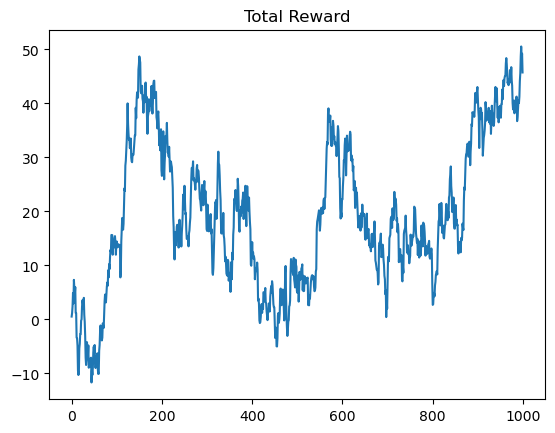

Text(0.5, 1.0, 'Average Reward Per Round')

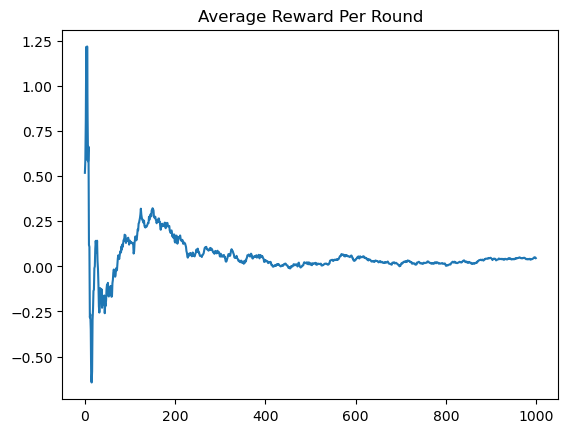

In [6]:
# As a naive baseline, practice a completely random strategy
reward_random = []
sumreward_random = []
avereward_random = []
p_value_random = {}
for t in range(T):
    # every time, randomly pull an arm
    arm = np.random.randint(low = 0, high = 10)
    reward_random.append(pull(arm))
    # record sum and average reward up to this round
    sumreward_random.append(np.sum(reward_random))
    avereward_random.append(np.mean(reward_random))

# Let's plot the sum and average reward over 1000 rounds
plt.plot(sumreward_random)
plt.title("Total Reward")
plt.show()

plt.plot(avereward_random)
plt.title("Average Reward Per Round")
plt.show()
# As you can imagine, it is pretty bad...
# Next time you are in a casino, don't just pull the machines randomly

### Approach 1: Greedy Strategy
In Stage2, greedy strategy will choose the current best treatment group everytime.

In [11]:
DISCOUNT = 0.8
curr_values = [0]*k  # initial values
counter = [0]*k  # initialize counter
# initialize reward dictionary
keys = [i for i in range(k)]
values = [[] for i in range(k)]
reward_dict = {keys[i]: values[i] for i in range(len(keys))}

min_sample_sizes = [0]*k  # initial minimum sample sizes
p_values = [0]*k # initial minimum sample sizes

reward_array = []
sumreward_array = []
avereward_array = []

def update_param(i, reward):
    reward_dict[i].append(reward)
    # keep counts
    counter[i] += 1
    # calcualte effect size and minimum sample size
    effect_size = np.mean(reward_dict[i])/np.std(reward_dict[i])
    min_sample_sizes[i] = min_sample_size(effect_size)
    # update p value
    p_values[i] = p_val(reward_dict[i])
    # update current value
    if p_values[i] <= 0.05:
        curr_values[i] = np.mean(reward_dict[i])
    else:
        curr_values[i] = np.mean(reward_dict[i])*DISCOUNT

    # update reward array for visualization
    reward_array.append(reward)
    # record sum and average reward up to this round
    sumreward_array.append(np.sum(reward_array))
    avereward_array.append(np.mean(reward_array))

In [12]:
# initialize as assigning 10 subjects into each treatment group
for t in range(10):
    for i in range(k):
        reward = pull(i)
        update_param(i, reward)

In [13]:
T_2 = T // 2
for t in range(100, T):
    # mark the end of stage 1 as:
    # all treatment groups have a stats sig result OR reach 80% power sample
    # OR when the agent runs out of 50% of all subjects
    reach_min_sample_size_condition = ((np.array(counter)-np.array(min_sample_sizes))>0)
    stats_sig_condition = (np.array(p_values) <= 0.05)
    stage1_end = (reach_min_sample_size_condition | stats_sig_condition)
    stage2_start = stage1_end.all() | (t >= T_2)
    if not stage2_start:
        # continue assign subjects into treatment groups not reaching stats sig result or have 80% power sample
        indices = np.where(stage1_end == False)
        i = np.random.choice(np.ravel(indices))
        reward = pull(i) 
        update_param(i, reward)
    else:
        # every time, assign subjects into the treatment group with the highest treatment effect
        i = np.argmax(curr_values)
        reward = pull(i)
        update_param(i, reward)

Text(0.5, 1.0, 'Total Reward')

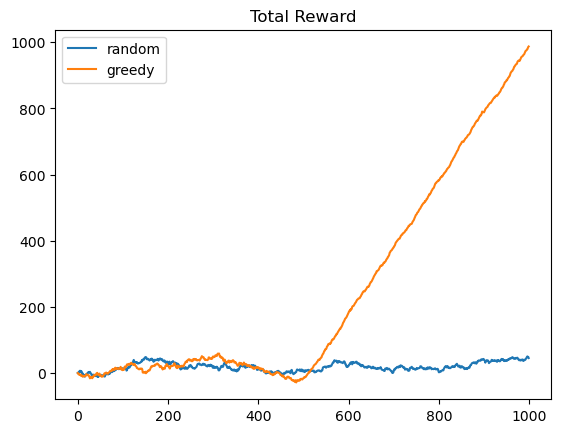

Text(0.5, 1.0, 'Average Reward Per Round')

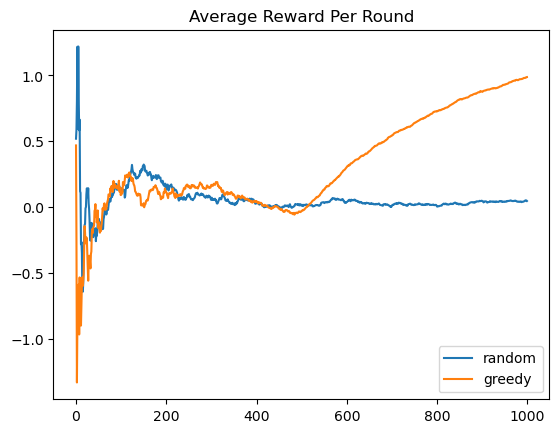

In [14]:
# Let's plot the sum and average reward over 1000 rounds
sumreward_greedy = sumreward_array.copy()
avereward_greedy = avereward_array.copy()

plt.plot(sumreward_random)
plt.plot(sumreward_greedy)
plt.title("Total Reward")
plt.legend(["random", "greedy"])
plt.show()

plt.plot(avereward_random)
plt.plot(avereward_greedy)
plt.title("Average Reward Per Round")
plt.legend(["random", "greedy"])
plt.show()

In [15]:
# Display treatment effects estimation and p values
p_values = np.array(p_values).round(decimals=3)
p_values_greedy = np.where(p_values <= 0.05, "Stats. Sig", p_values)

TE_est = np.array(curr_values).round(decimals=3)
TE_est_greedy = np.where(p_values <= 0.05, TE_est, TE_est/0.8)

TE_results = pd.DataFrame(data = {'Group':range(k)})
TE_results['TE_est_greedy'] = TE_est_greedy
TE_results['p_values_greedy'] = p_values_greedy

In [16]:
TE_results

,Group,TE_est_greedy,p_values_greedy
0,0,-0.07125,0.426
1,1,-0.57500,Stats. Sig
2,2,-0.49500,Stats. Sig
3,3,1.11500,Stats. Sig
4,4,-0.88800,Stats. Sig
5,5,0.19125,0.489
6,6,0.24375,0.518
7,7,0.06375,0.772
8,8,2.01200,Stats. Sig
9,9,-0.04625,0.921


### Approach 2: $\varepsilon$-greedy strategy
In Stage2, $\varepsilon$-greedy strategy forces to keep exploring with a probability $\varepsilon$, otherwise will choose the current best treatment group.

In [23]:
curr_values = [0]*k  # initial values
counter = [0]*k  # initialize counter
# initialize reward dictionary
keys = [i for i in range(k)]
values = [[] for i in range(k)]
reward_dict = {keys[i]: values[i] for i in range(len(keys))}

min_sample_sizes = [0]*k  # initial minimum sample sizes
p_values = [0]*k # initial minimum sample sizes

reward_array = []
sumreward_array = []
avereward_array = []

eps = 0.2 # force to explore 10% of the time

In [24]:
# initialize as assigning 10 subjects into each treatment group
for t in range(10):
    for i in range(k):
        reward = pull(i)
        update_param(i, reward)

In [25]:
T_2 = T // 2
for t in range(100, T):
    # mark the end of stage 1 as:
    # all treatment groups have a stats sig result OR reach 80% power sample
    # OR when the agent runs out of 50% of all subjects
    reach_min_sample_size_condition = ((np.array(counter)-np.array(min_sample_sizes))>0)
    stats_sig_condition = (np.array(p_values) <= 0.05)
    stage1_end = (reach_min_sample_size_condition | stats_sig_condition)
    stage2_start = stage1_end.all() | (t >= T_2)
    if not stage2_start:
        # continue assign subjects into treatment groups not reaching stats sig result or have 80% power sample
        indices = np.where(stage1_end == False)
        i = np.random.choice(np.ravel(indices))
        reward = pull(i) 
        update_param(i, reward)
    else:
        # every time, assign subjects into the treatment group with the highest treatment effect
        i = np.argmax(curr_values)
        # throw a coin
        explore = np.random.binomial(1, eps)
        if explore:
            # randomly pull another arm
            i = np.random.choice(np.setdiff1d(range(k), arm))
        reward = pull(i)
        update_param(i, reward)

Text(0.5, 1.0, 'Total Reward')

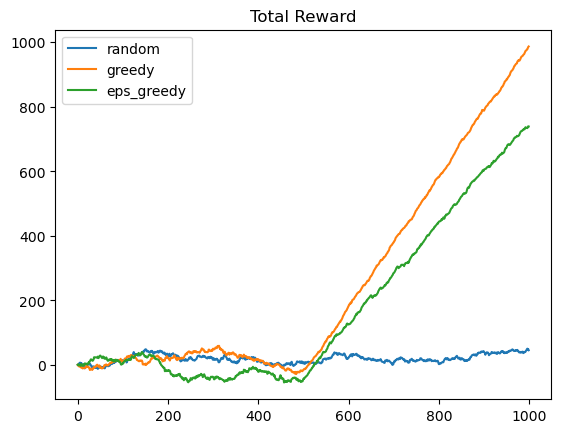

Text(0.5, 1.0, 'Average Reward Per Round')

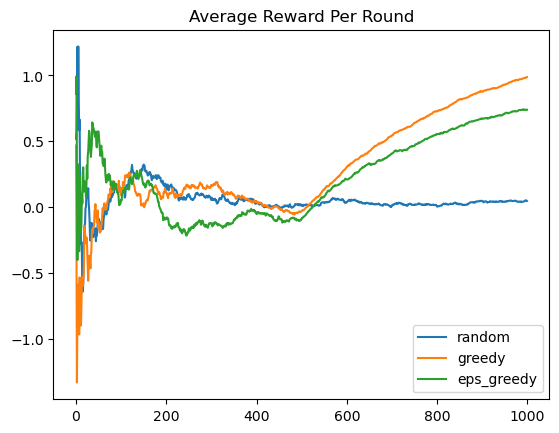

In [26]:
# Let's plot the sum and average reward over 1000 rounds
sumreward_eps_greedy = sumreward_array.copy()
avereward_eps_greedy = avereward_array.copy()

plt.plot(sumreward_random)
plt.plot(sumreward_greedy)
plt.plot(sumreward_eps_greedy)
plt.title("Total Reward")
plt.legend(["random", "greedy", "eps_greedy"])
plt.show()

plt.plot(avereward_random)
plt.plot(avereward_greedy)
plt.plot(avereward_eps_greedy)
plt.title("Average Reward Per Round")
plt.legend(["random", "greedy", "eps_greedy"])
plt.show()

In [27]:
# Display treatment effects estimation and p values
p_values = np.array(p_values).round(decimals=3)
p_values_eps_greedy = np.where(p_values <= 0.05, "Stats. Sig", p_values)

TE_est = np.array(curr_values).round(decimals=3)
TE_est_eps_greedy = np.where(p_values <= 0.05, TE_est, TE_est/0.8)

TE_results['TE_est_eps_greedy'] = TE_est_eps_greedy
TE_results['p_values_eps_greedy'] = p_values_eps_greedy

In [28]:
TE_results

,Group,TE_est_greedy,p_values_greedy,TE_est_eps_greedy,p_values_eps_greedy
0,0,-0.07125,0.426,-0.31800,Stats. Sig
1,1,-0.57500,Stats. Sig,-1.50300,Stats. Sig
2,2,-0.49500,Stats. Sig,-0.94400,Stats. Sig
3,3,1.11500,Stats. Sig,0.56300,Stats. Sig
4,4,-0.88800,Stats. Sig,-1.06800,Stats. Sig
5,5,0.19125,0.489,-0.45500,0.078
6,6,0.24375,0.518,0.52375,0.052
7,7,0.06375,0.772,0.11250,0.591
8,8,2.01200,Stats. Sig,1.89500,Stats. Sig
9,9,-0.04625,0.921,-0.16000,0.6


### Approach 3: Gradient method
In Stage2, gradient method estimates the probability that each action should be taken, and then revises these probability estimates in an iterative manner.

In [34]:
curr_values = [0]*k  # initial values
counter = [0]*k  # initialize counter
# initialize reward dictionary
keys = [i for i in range(k)]
values = [[] for i in range(k)]
reward_dict = {keys[i]: values[i] for i in range(len(keys))}

min_sample_sizes = [0]*k  # initial minimum sample sizes
p_values = [0]*k # initial minimum sample sizes

reward_array = []
sumreward_array = []
avereward_array = []

In [35]:
# Gradient method
def softmax(x):
    return np.exp(x)/sum(np.exp(x))


H = [0]*k  # initial preference scores. Doesn't matter that much how you initialize them, as long as different actions have the same initial score
prob = softmax(H)  # initialize probabilities
alpha = 0.1  # step size

In [36]:
# initialize as assigning 10 subjects into each treatment group
for t in range(10):
    for i in range(k):
        reward = pull(i)
        update_param(i, reward)

In [37]:
T_2 = T // 2
for t in range(100, T):
    # mark the end of stage 1 as:
    # all treatment groups have a stats sig result OR reach 80% power sample
    # OR when the agent runs out of 50% of all subjects
    reach_min_sample_size_condition = ((np.array(counter)-np.array(min_sample_sizes))>0)
    stats_sig_condition = (np.array(p_values) <= 0.05)
    stage1_end = (reach_min_sample_size_condition | stats_sig_condition)
    stage2_start = stage1_end.all() | (t >= T_2)
    if not stage2_start:
        # continue assign subjects into treatment groups not reaching stats sig result or have 80% power sample
        indices = np.where(stage1_end == False)
        i = np.random.choice(np.ravel(indices))
        reward = pull(i) 
        update_param(i, reward)
    else:
        # choose an arm based on probabilities
        arm = np.random.choice(range(k), p = prob) 
        reward = pull(arm)
        update_param(arm, reward)
        avereward = np.mean(avereward_array)
    
        # update prob
        for i in range(k):
            if i == arm:
                H[i] = H[i] + alpha*(reward - avereward)*(1-prob[i])
            else:
                H[i] = H[i] - alpha*(reward - avereward)*prob[i]
        prob = softmax(H)

    

Text(0.5, 1.0, 'Total Reward')

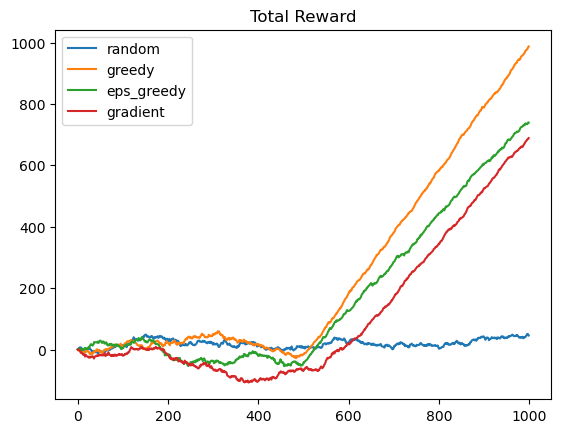

Text(0.5, 1.0, 'Average Reward Per Round')

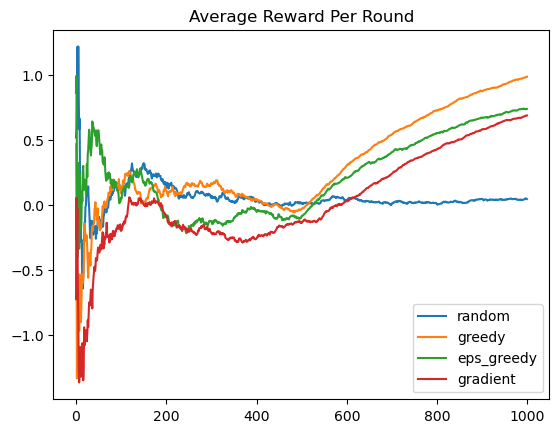

In [38]:
# Let's plot the sum and average reward over 1000 rounds
sumreward_gradient = sumreward_array.copy()
avereward_gradient = avereward_array.copy()

plt.plot(sumreward_random)
plt.plot(sumreward_greedy)
plt.plot(sumreward_eps_greedy)
plt.plot(sumreward_gradient)
plt.title("Total Reward")
plt.legend(["random", "greedy", "eps_greedy", "gradient"])
plt.show()

plt.plot(avereward_random)
plt.plot(avereward_greedy)
plt.plot(avereward_eps_greedy)
plt.plot(avereward_gradient)
plt.title("Average Reward Per Round")
plt.legend(["random", "greedy", "eps_greedy", "gradient"])
plt.show()

In [41]:
# Display treatment effects estimation and p values
p_values = np.array(p_values).round(decimals=3)
p_values_gradient = np.where(p_values <= 0.05, "Stats. Sig", p_values)

TE_est = np.array(curr_values).round(decimals=3)
TE_est_gradient = np.where(p_values <= 0.05, TE_est, TE_est/0.8)

TE_results['TE_est_gradient'] = TE_est_gradient
TE_results['p_values_gradient'] = p_values_gradient

In [42]:
TE_results

,Group,TE_est_greedy,p_values_greedy,TE_est_eps_greedy,p_values_eps_greedy,TE_est_gradient,p_values_gradient
0,0,-0.07125,0.426,-0.31800,Stats. Sig,-0.29800,Stats. Sig
1,1,-0.57500,Stats. Sig,-1.50300,Stats. Sig,-0.80600,Stats. Sig
2,2,-0.49500,Stats. Sig,-0.94400,Stats. Sig,-0.65200,Stats. Sig
3,3,1.11500,Stats. Sig,0.56300,Stats. Sig,1.06600,Stats. Sig
4,4,-0.88800,Stats. Sig,-1.06800,Stats. Sig,-0.85700,Stats. Sig
5,5,0.19125,0.489,-0.45500,0.078,-0.05000,0.816
6,6,0.24375,0.518,0.52375,0.052,0.32125,0.21
7,7,0.06375,0.772,0.11250,0.591,0.10750,0.544
8,8,2.01200,Stats. Sig,1.89500,Stats. Sig,1.81500,Stats. Sig
9,9,-0.04625,0.921,-0.16000,0.6,-0.69625,0.075


<a id='section04'></a>
## Results Summary
* Given the design, all 3 strategies, Greedy strategy, $\varepsilon$-greedy strategy, and Gradient method start to outrun the random strategy starting half of all subjects are assigned.
* Greedy strategy has the best total and average reward, however half of the treatment groups do not have a significant estimate for treatment effect (p-values are large).
* $\varepsilon$-greedy strategy explore more than greedy strategy, which could explain why it is slightly off in terms of rewards, but has more significant treatment effect estimations.
* Gradient method shows the least total and average reward and is worse than $\varepsilon$-greedy strategy in terms of statistical siginificance in terms of treamtment effect estimation.